In [1]:
import pandas as pd
import os
import glob
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from jupyterthemes import jtplot
import pickle
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates

# import requests
# from bs4 import BeautifulSoup
import git

jtplot.style()

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



If the cell above gives any errors for missing packages, simply:
`!pip install PACKAGE`,

where `PACKAGE` is the missing package, e.g. for git: it's 

`!pip install GitPython`

# Update data

check remote git:
    
`git remote show origin`

In [2]:
git_dir = r'./COVID-19/'

g = git.cmd.Git(git_dir)
g.fetch()
g.pull()

'Updating 1eb3728..277426f\nFast-forward\n README.md                                          |    2 +\n ...ime_series_19-covid-Confirmed_archived_0325.csv |  971 +++---\n .../time_series_19-covid-Deaths_archived_0325.csv  |  971 +++---\n ...ime_series_19-covid-Recovered_archived_0325.csv |  971 +++---\n .../csse_covid_19_daily_reports/03-20-2020.csv     |  300 ++\n .../csse_covid_19_daily_reports/03-21-2020.csv     |  305 ++\n .../csse_covid_19_daily_reports/03-22-2020.csv     | 3418 +++++++++++++++++++\n .../csse_covid_19_daily_reports/03-23-2020.csv     | 3416 +++++++++++++++++++\n .../csse_covid_19_daily_reports/03-24-2020.csv     | 3418 +++++++++++++++++++\n .../csse_covid_19_daily_reports/03-25-2020.csv     | 3421 ++++++++++++++++++++\n .../csse_covid_19_time_series/README.md            |    7 +\n .../time_series_covid19_confirmed_global.csv       |  246 ++\n .../time_series_covid19_deaths_global.csv          |  246 ++\n .../time_series_covid19_recovered_global.csv       |  234 +

# Create the dataframe from the different files

In [3]:
# dates of measures

minor_measures = {
    'United Kingdom':'17/03/2020',
    'US':'15/03/2020'
}

nationwide_measures = {
    'China':'23/01/2020',
    'Greece':'15/03/2020',
    'Italy':'10/03/2020',
    'Spain':'15/03/2020',
    'France':'17/03/2020',
    'Costa Rica':'16/03/2020',
    'Luxembourg':'16/03/2020',
    'Czechia':'16/03/2020',

    'Belgium':'16/03/2020'
}

In [31]:
ending = 'csv'
path_to_files = r'./COVID-19/csse_covid_19_data/csse_covid_19_time_series'

all_paths = glob.glob(os.path.join(path_to_files, f'*.{ending}'))

In [32]:
all_paths

['./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
 './COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

In [45]:
df_list = list()

for f in all_paths:
    foo = pd.read_csv(f)
    foo = pd.melt(foo, id_vars=[
                  'Province/State', 'Country/Region', 'Lat', 'Long'], var_name=['Date'])
    foo['Date'] = pd.to_datetime(foo['Date'])
    foo.columns = foo.columns.str.replace(
        'value', f.split("_")[-2].capitalize())
    foo['Province/State'].fillna(foo['Country/Region'], inplace=True)
    foo.set_index(['Province/State', 'Country/Region',
                   'Date', 'Lat', 'Long'], inplace=True)
    df_list.append(foo)

In [46]:
df = pd.concat(df_list, axis = 1).reset_index()
df.shape

(16499, 8)

In [7]:
# europe = dict()

# URL = "https://en.wikipedia.org/wiki/Member_state_of_the_European_Union"

# res = requests.get(URL).text
# soup = BeautifulSoup(res,'lxml')
# for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
#     data = items.find_all(['th','td'])
#     try:
#         country = data[0].a.text
#         europe[country] = 'EU'
#     except IndexError:
#         pass

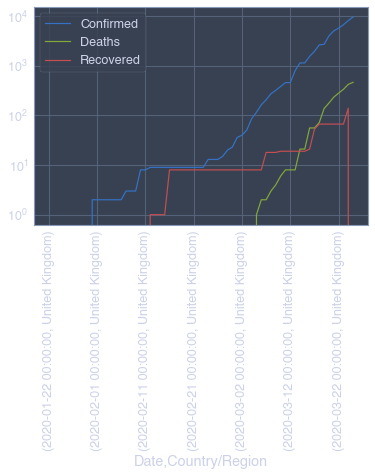

In [47]:
df[df['Country/Region'] == 'United Kingdom'].groupby(
    ['Date', 'Country/Region']).sum()[['Confirmed', 'Deaths', 'Recovered']].plot(logy = True, rot = 90)

In [235]:
# Save to pickle

# with open('country_continent.pickle', 'wb') as handle:
#     pickle.dump(country_continent, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# Read pickle
with open('country_continent.pickle', 'rb') as handle:
    country_continent = pickle.load(handle)

In [49]:
df2 = df.copy()
df2['Date_1'] = df2['Date'] + pd.Timedelta(days=1)
df2.rename(columns={'Confirmed': 'Confrimed_1',
                    'Deaths': 'Deaths_1',
                    'Recovered': 'Recovered_1',
                    'Date': 'Date_Minus_1'}, inplace=True)

In [50]:
df3 = df.merge(df2[['Province/State',
                    'Country/Region',
                    'Confrimed_1',
                    'Deaths_1',
                    'Recovered_1',
                    'Date_1',
                    'Date_Minus_1']], how='left',
               left_on=['Province/State', 'Country/Region', 'Date'],
               right_on=['Province/State', 'Country/Region', 'Date_1'])

In [51]:
df3['ConfirmedDaily'] = df3['Confirmed'] - df3['Confrimed_1']
df3['DeathsDaily'] = df3['Deaths'] - df3['Deaths_1']
df3['RecoveredDaily'] = df3['Recovered'] - df3['Recovered_1']

In [52]:
df3['ConfirmedDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Confirmed']
df3['DeathsDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Deaths']
df3['RecoveredDaily'].loc[df3['Date'] == '2020-01-22'] = df3['Recovered']

del df3['Confrimed_1']
del df3['Deaths_1']
del df3['Recovered_1']
del df3['Date_1']
del df3['Date_Minus_1']

/Users/Arapidis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df3.DeathsDaily.sum(), df3.ConfirmedDaily.sum(), df3.RecoveredDaily.sum()

(21180.0, 467593.0, 108000.0)

In [54]:
df3['MonthYear'] = df3['Date'].dt.strftime('%b-%Y')

In [55]:
df3['Continent'] = df3['Country/Region'].map(country_continent)

In [56]:
if len(df3[df3['Continent'].isna()]) == 0:
    print(30*'+'+' All good ' + 30*'+')
else:
    print(30*'-'+' Check ' + 30*'-')

------------------------------ Check ------------------------------


In [57]:
df3['DeathRate'] = df3['Deaths'] / df3['Confirmed']
df3['RecoveredRate'] = df3['Recovered'] / df3['Confirmed']

In [58]:
df3.groupby(['Country/Region']).sum()[['ConfirmedDaily']
                                      ].sort_values(ascending=False,
                                                    by='ConfirmedDaily').reset_index().head(10)

,Country/Region,ConfirmedDaily
0,China,81661.0
1,Italy,74386.0
2,US,65778.0
3,Spain,49515.0
4,Germany,37323.0
5,Iran,27017.0
6,France,25600.0
7,Switzerland,10897.0
8,United Kingdom,9640.0
9,"Korea, South",9137.0


In [59]:
df3.groupby(['Country/Region']).sum()[['ConfirmedDaily']
                                      ].sort_values(ascending=False,
                                                    by='ConfirmedDaily').sum()

ConfirmedDaily    467593.0
dtype: float64

# Plots

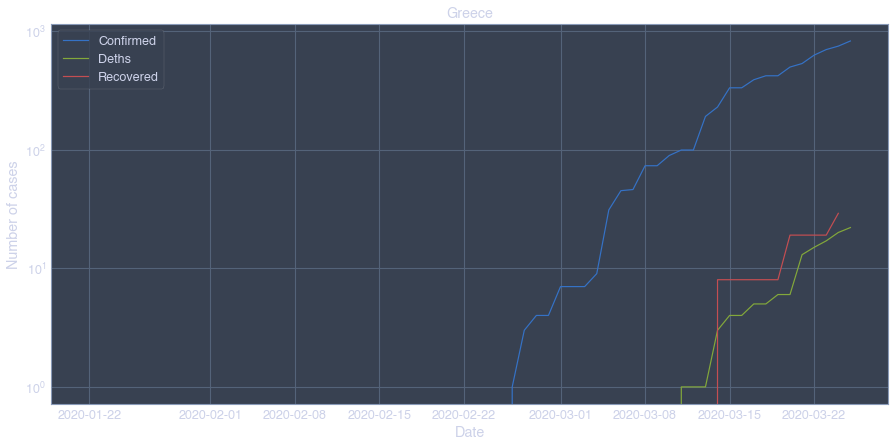

In [60]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

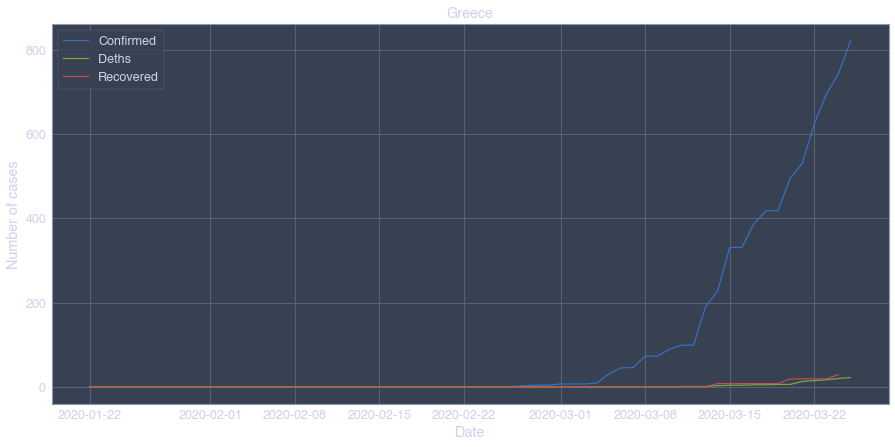

In [61]:
c = 'Greece'
x = df3[df3['Country/Region'] == c]['Date']
y1 = df3[df3['Country/Region'] == c]['Confirmed']
y2 = df3[df3['Country/Region'] == c]['Deaths']
y3 = df3[df3['Country/Region'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

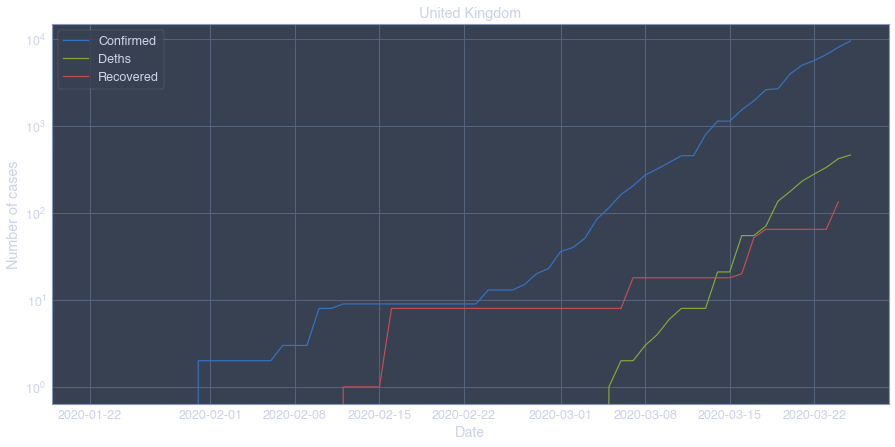

In [62]:
c = 'United Kingdom'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.semilogy(x, y1, label = 'Confirmed')
plt.semilogy(x, y2, label = 'Deths')
plt.semilogy(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

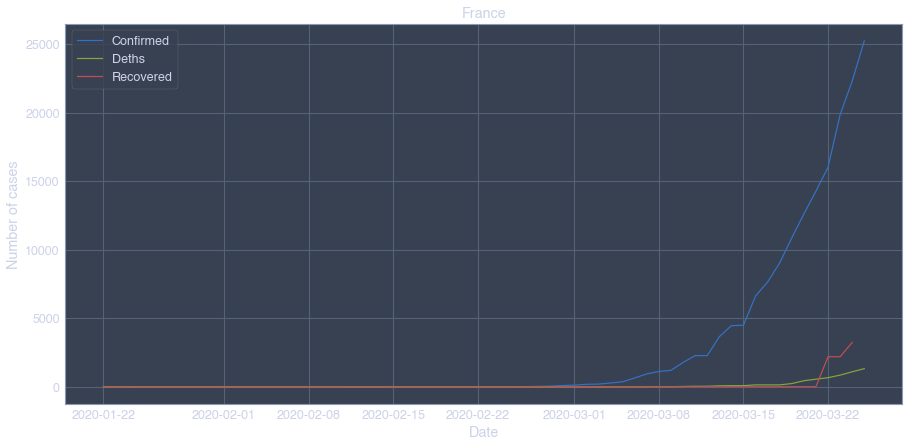

In [63]:
c = 'France'
x = df3[df3['Province/State'] == c]['Date']
y1 = df3[df3['Province/State'] == c]['Confirmed']
y2 = df3[df3['Province/State'] == c]['Deaths']
y3 = df3[df3['Province/State'] == c]['Recovered']

plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'Confirmed')
plt.plot(x, y2, label = 'Deths')
plt.plot(x, y3, label = 'Recovered')
plt.ylabel('Number of cases')
plt.xlabel('Date')
plt.title(c)
plt.legend()
plt.show()

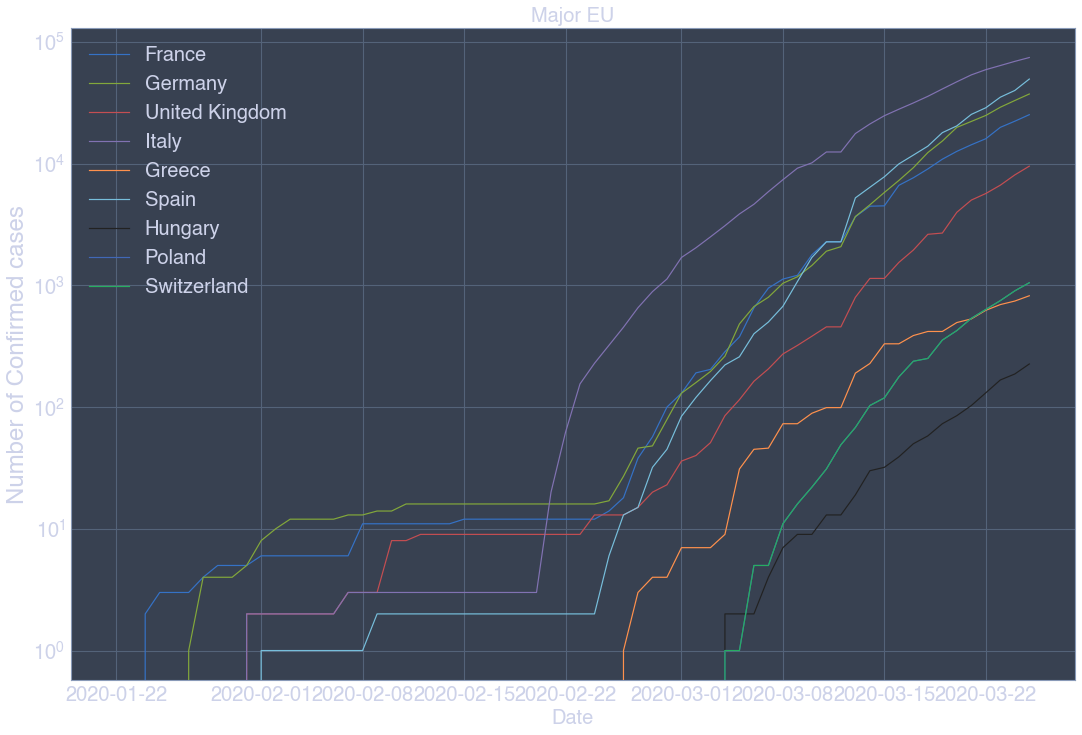

In [64]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']
y9 = df3[df3['Province/State'] == 'Switzerland']['Confirmed']




plt.figure(figsize = (18, 12))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y8, label = 'Switzerland')


plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Confirmed cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_confirmed.png', dpi = 600, bbox_inches= 'tight')

plt.show()

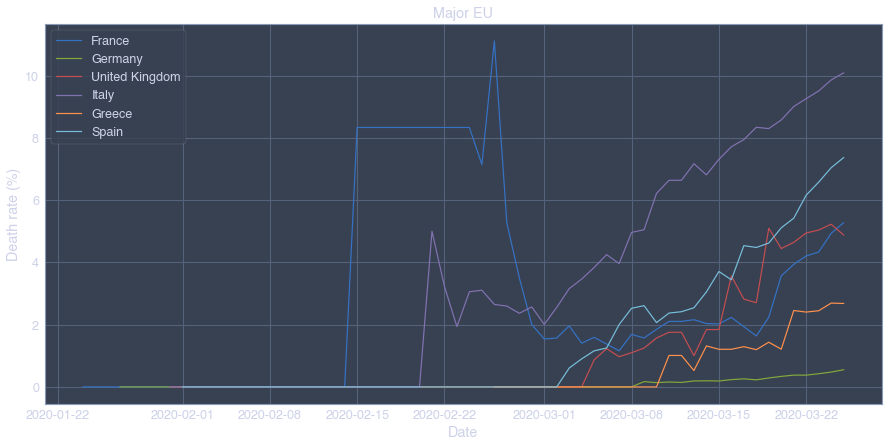

In [65]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['DeathRate'] * 100
y2 = df3[df3['Province/State'] == 'Germany']['DeathRate'] * 100
y3 = df3[df3['Province/State'] == 'United Kingdom']['DeathRate'] * 100
y4 = df3[df3['Province/State'] == 'Italy']['DeathRate'] * 100
y5 = df3[df3['Province/State'] == 'Greece']['DeathRate'] * 100
y6 = df3[df3['Province/State'] == 'Spain']['DeathRate'] * 100




plt.figure(figsize = (15, 7))
plt.plot(x, y1, label = 'France')
plt.plot(x, y2, label = 'Germany')
plt.plot(x, y3, label = 'United Kingdom')
plt.plot(x, y4, label = 'Italy')
plt.plot(x, y5, label = 'Greece')
plt.plot(x, y6, label = 'Spain')

plt.ylabel('Death rate (%)')
plt.xlabel('Date')
plt.title('Major EU')
plt.legend()
plt.show()

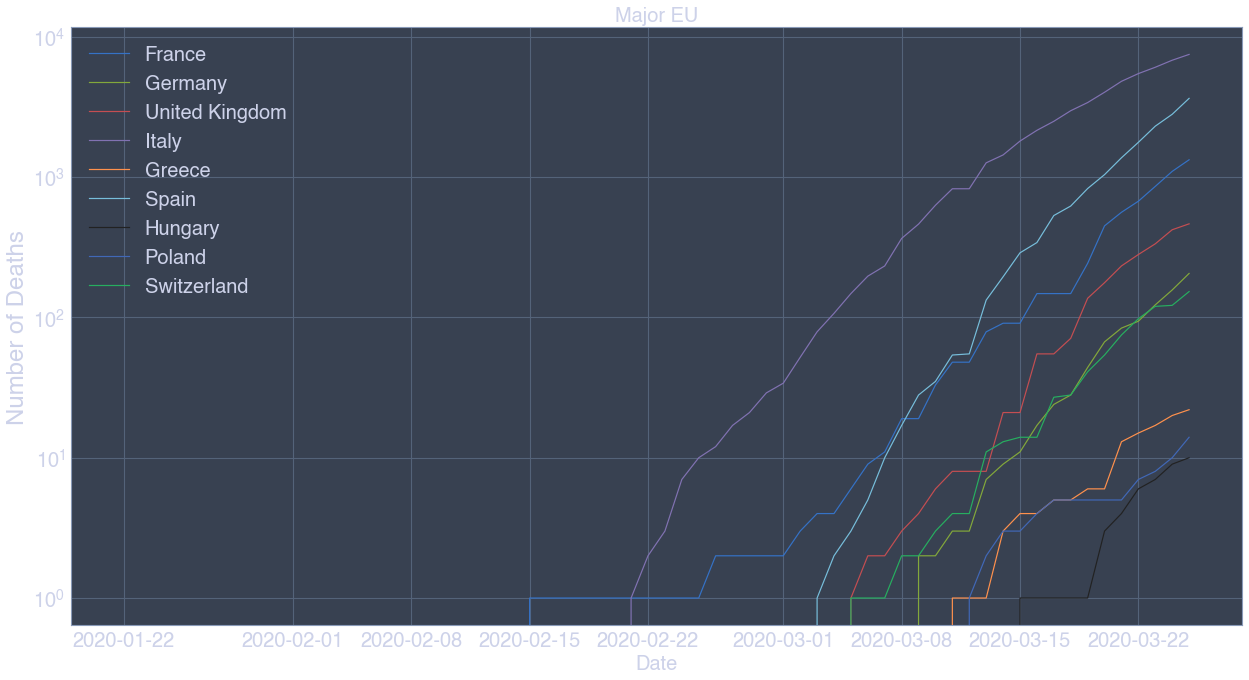

In [66]:

x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Deaths']
y2 = df3[df3['Province/State'] == 'Germany']['Deaths']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y4 = df3[df3['Province/State'] == 'Italy']['Deaths']
y5 = df3[df3['Province/State'] == 'Greece']['Deaths']
y6 = df3[df3['Province/State'] == 'Spain']['Deaths']
y7 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y8 = df3[df3['Province/State'] == 'Poland']['Deaths']
y9 = df3[df3['Province/State'] == 'Switzerland']['Deaths']



plt.figure(figsize = (21, 11))
plt.semilogy(x, y1, label = 'France')
plt.semilogy(x, y2, label = 'Germany')
plt.semilogy(x, y3, label = 'United Kingdom')
plt.semilogy(x, y4, label = 'Italy')
plt.semilogy(x, y5, label = 'Greece')
plt.semilogy(x, y6, label = 'Spain')
plt.semilogy(x, y7, label = 'Hungary')
plt.semilogy(x, y8, label = 'Poland')
plt.semilogy(x, y9, label = 'Switzerland')

plt.xlabel('Date', fontsize = 20)
plt.title('Major EU', fontsize = 20)
plt.ylabel('Number of Deaths', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.savefig('eu_countries_deaths.png', dpi = 600, bbox_inches= 'tight')

plt.show()

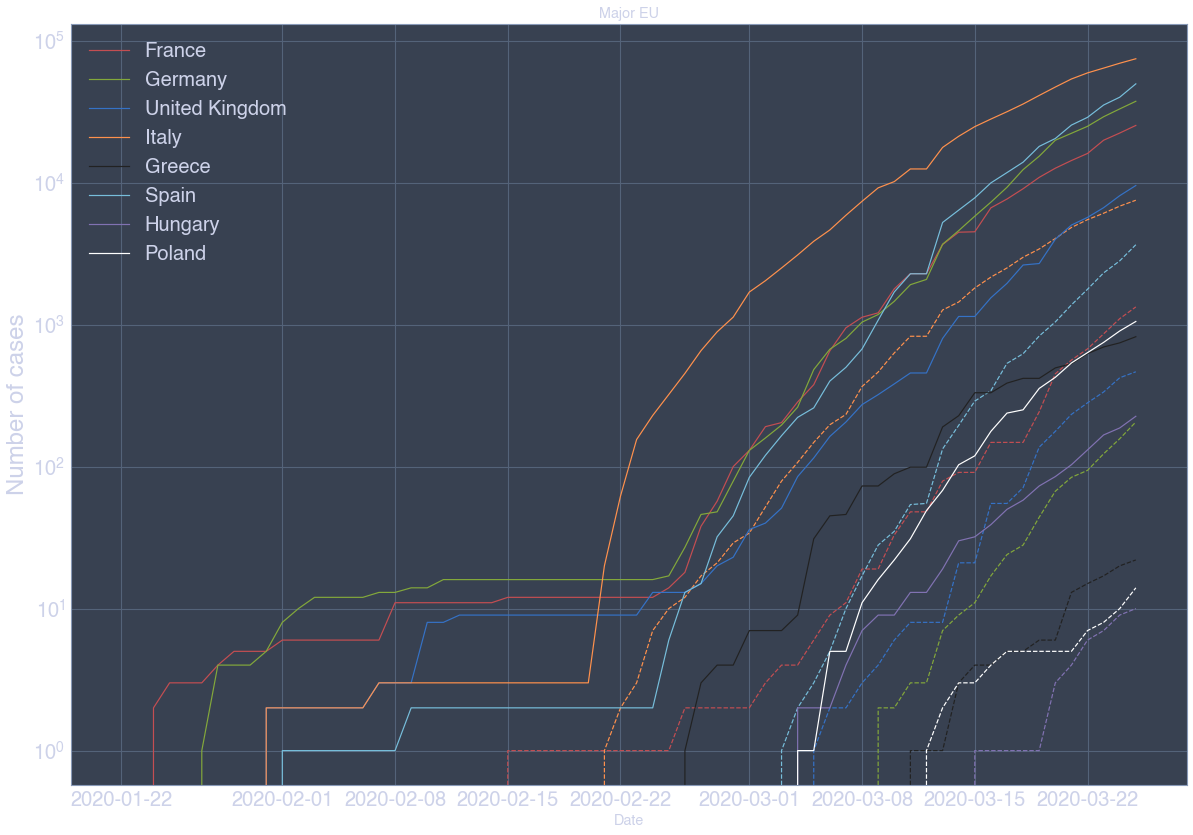

In [67]:
plt.figure(figsize = (20, 14))
x = df3[df3['Province/State'] == 'France']['Date']
y1 = df3[df3['Province/State'] == 'France']['Confirmed']
y2 = df3[df3['Province/State'] == 'Germany']['Confirmed']
y3 = df3[df3['Province/State'] == 'United Kingdom']['Confirmed']
y4 = df3[df3['Province/State'] == 'Italy']['Confirmed']
y5 = df3[df3['Province/State'] == 'Greece']['Confirmed']
y6 = df3[df3['Province/State'] == 'Spain']['Confirmed']
y7 = df3[df3['Province/State'] == 'Hungary']['Confirmed']
y8 = df3[df3['Province/State'] == 'Poland']['Confirmed']

y12 = df3[df3['Province/State'] == 'France']['Deaths']
y22 = df3[df3['Province/State'] == 'Germany']['Deaths']
y32 = df3[df3['Province/State'] == 'United Kingdom']['Deaths']
y42 = df3[df3['Province/State'] == 'Italy']['Deaths']
y52 = df3[df3['Province/State'] == 'Greece']['Deaths']
y62 = df3[df3['Province/State'] == 'Spain']['Deaths']
y72 = df3[df3['Province/State'] == 'Hungary']['Deaths']
y82 = df3[df3['Province/State'] == 'Poland']['Deaths']


plt.semilogy(x, y12, '--r')
plt.semilogy(x, y22, '--g')
plt.semilogy(x, y32, '--b')
plt.semilogy(x, y42, '--y')
plt.semilogy(x, y52, '--k')
plt.semilogy(x, y62, '--c')
plt.semilogy(x, y72, '--m')
plt.semilogy(x, y82, '--w')

plt.semilogy(x, y1, '-r', label = 'France')
plt.semilogy(x, y2, '-g', label = 'Germany')
plt.semilogy(x, y3, '-b', label = 'United Kingdom')
plt.semilogy(x, y4, '-y', label = 'Italy')
plt.semilogy(x, y5, '-k', label = 'Greece')
plt.semilogy(x, y6, '-c', label = 'Spain')
plt.semilogy(x, y7, '-m', label = 'Hungary')
plt.semilogy(x, y8, '-w', label = 'Poland')

plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.title('Major EU')
plt.ylabel('Number of cases', fontsize=24)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=20)
plt.show()

In [68]:
df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()

,Date,Lat,Long,Confirmed,Recovered,Deaths,ConfirmedDaily,DeathsDaily,RecoveredDaily,DeathRate,RecoveredRate
0,2020-01-22,1221.2567,4148.7313,548.0,28.0,17.0,548.0,17.0,28.0,0.038288,0.063063
1,2020-01-23,1497.0967,5077.3545,668.0,30.0,18.0,95.0,1.0,2.0,1.038288,0.125563
2,2020-01-24,1497.0967,5077.3545,958.0,37.0,27.0,277.0,8.0,6.0,1.043716,0.145236
3,2020-01-25,1497.0967,5077.3545,1491.0,40.0,43.0,486.0,16.0,3.0,0.399785,0.188156
4,2020-01-26,1497.0967,5077.3545,2229.0,50.0,59.0,669.0,14.0,10.0,0.333502,0.127046
...,...,...,...,...,...,...,...,...,...,...,...
59,2020-03-21,1497.0967,5077.3545,83618.0,74069.0,3299.0,55.0,6.0,591.0,0.454127,27.009966
60,2020-03-22,1497.0967,5077.3545,83773.0,74578.0,3315.0,130.0,15.0,505.0,0.455110,26.766463
61,2020-03-23,1497.0967,5077.3545,83836.0,75030.0,3315.0,63.0,0.0,452.0,0.452640,26.682801
62,2020-03-24,1497.0967,5077.3545,83939.0,75500.0,3322.0,93.0,7.0,466.0,0.450072,26.648458


In [69]:
df3.to_csv('data_v0.4.csv')

In [70]:
foo = df3.groupby(['Continent', 'Date']).sum().reset_index()

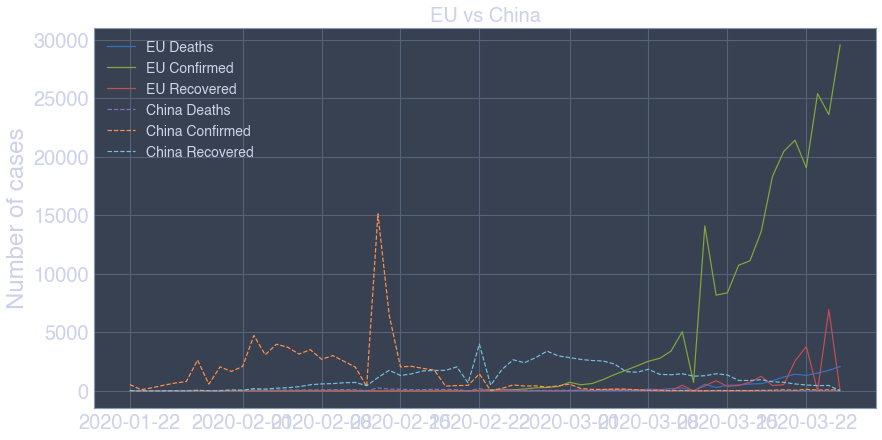

In [71]:
plt.figure(figsize=(14, 7))
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['DeathsDaily'], label='EU Deaths')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['ConfirmedDaily'], label='EU Confirmed')
plt.plot(foo[foo['Continent'] == 'Europe']['Date'],
         foo[foo['Continent'] == 'Europe']['RecoveredDaily'], label='EU Recovered')

plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['DeathsDaily'],
         '--', label='China Deaths')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['ConfirmedDaily'],
         '--', label='China Confirmed')
plt.plot(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
         df3[df3['Country/Region'] ==
             'China'].groupby('Date').sum().reset_index()['RecoveredDaily'],
         '--', label='China Recovered')

plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-g', linewidth=2, markersize=10, label='EU Recovered')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b', linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '--g', linewidth=2, markersize=10, label='China Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_china.png', dpi = 600, bbox_inches= 'tight')

plt.show()

In [ ]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-r', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-b',  linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-g', linewidth=2, markersize=10, label='EU Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '--r', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '--b',  linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '--g',  linewidth=2, markersize=10, label='China Recovered')



plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Deaths'],
             '-.r', linewidth=2, markersize=10, label='US Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Confirmed'],
             '-.b',  linewidth=2, markersize=10, label='US Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Recovered'],
             '-.g',  linewidth=2, markersize=10, label='US Recovered')


plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.savefig('eu_vs_us_vs_china.png', dpi = 600, bbox_inches= 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(21, 12))
plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Deaths'],
             '-s', color='#F1948A', linewidth=2, markersize=10,  label='EU Deaths')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Confirmed'],
             '-s', color = '#5DADE2', linewidth=2, markersize=10, label='EU Confirmed')

plt.semilogy(foo[foo['Continent'] == 'Europe']['Date'],
             foo[foo['Continent'] == 'Europe']['Recovered'],
             '-s', color='#58D68D', linewidth=2, markersize=10, label='EU Recovered')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Deaths'],
             '-.^', color='#C0392B', linewidth=2, markersize=10, label='China Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Confirmed'],
             '-.^', color='#2471A3', linewidth=2, markersize=10, label='China Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'China'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'China'].groupby('Date').sum().reset_index()['Recovered'],
             '-.^', color='#229954', linewidth=2, markersize=10, label='China Recovered')


plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Deaths'],
             '--o', color='#943126', linewidth=2, markersize=10, label='US Deaths')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Confirmed'],
             '--o', color='#21618C', linewidth=2, markersize=10, label='US Confirmed')

plt.semilogy(df3[df3['Country/Region'] == 'US'].groupby('Date').sum().reset_index()['Date'],
             df3[df3['Country/Region'] ==
                 'US'].groupby('Date').sum().reset_index()['Recovered'],
             '--o', color='#186A3B', linewidth=2, markersize=10, label='US Recovered')

plt.ylabel('Number of cases', fontsize=24)
plt.title('EU vs China', fontsize=20)
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

In [ ]:
plt.semilogy(df3.groupby('Date').sum().reset_index()['Date'], 
         df3.groupby('Date').sum().reset_index()['Confirmed'])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
c = 'France'
x = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change().index
y = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change()['Confirmed']
y2 = df3[df3['Country/Region'] ==
    c].groupby('Date').sum()[['Confirmed', 'Deaths']].pct_change()['Deaths']

plt.plot(x, y)
plt.plot(x, y2)
plt.ylim(0, 1)
plt.show()

In [ ]:
df3.head()

In [ ]:
eu = df3[df3['Continent'] == 'Europe']
eu.head()

In [ ]:
eu = eu.groupby(['Date', 'Country/Region']
                ).sum()[['Recovered', 'Deaths', 'Confirmed']].reset_index()

In [ ]:
eu_confirmed = eu[['Date', 'Country/Region', 'Confirmed']]
eu_deaths = eu[['Date', 'Country/Region', 'Deaths']]

In [ ]:
cm_conf = eu_confirmed.pivot(
    index='Date', columns='Country/Region', values='Confirmed').corr()
cm_deaths = eu_deaths.pivot(
    index='Date', columns='Country/Region', values='Deaths').corr()

In [ ]:
plt.matshow(cm_conf)
plt.show()

In [ ]:
cm_conf.style.background_gradient()

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cm_conf[cm_conf['Italy'] > 0.6][['Italy']],
            mask=np.zeros_like(cm_conf[cm_conf['Italy'] > 0.6][['Italy']],
                               dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig('corr_conf.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(cm_deaths[cm_deaths['Italy'] > 0.6][['Italy']],
            mask=np.zeros_like(cm_deaths[cm_deaths['Italy'] > 0.6][['Italy']],
                               dtype=np.bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.savefig('corr_deaths.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
sns.heatmap(cm_deaths[['Italy']],
            cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [ ]:
foo = df3[df3['Confirmed'] > 10]
x3 = foo[foo['Province/State'] == 'France']['Date']

x4 = foo[foo['Province/State'] == 'Italy']['Date']

y3 = foo[foo['Province/State'] == 'France']['Confirmed']
y4 = foo[foo['Province/State'] == 'Italy']['Confirmed']

fig, ax = plt.subplots(figsize = (20,12))

days = mdates.DayLocator()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(days)


ax.semilogy(x3, y3, label = 'France')
ax.semilogy(x4, y4, label = 'Italy')


ax.set_title('France vs Italy', fontsize = 20)
ax.set_ylabel('Number of Confirmed Cases', fontsize = 24)
ax.tick_params(axis = 'x', labelsize=20, rotation=90)
ax.tick_params(axis = 'y', labelsize=20)
ax.set_xticks(x4)
# ax.set_yticks(fontsize=20)


plt.legend(frameon=False, fontsize=20)
plt.savefig('Italy_France.png', dpi = 600, bbox_inches= 'tight')

plt.show()